# Anomaly Detection using DARTS
Inspired by [this post](https://towardsdatascience.com/low-code-time-series-analysis-2d5d02b5474b)   
Nov 4th 2023

In [19]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import darts
from darts.ad import QuantileDetector

In [3]:
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plotsize = (22, 5)
plt.rcParams['figure.figsize']= plotsize
# Pandas config
pd.options.display.float_format= '{:,.4f}'.format

## 1) Input Data
Data comes from this [Kaggle dataset](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data?select=DailyDelhiClimateTrain.csv)

In [9]:
df = pd.read_csv("DailyDelhiClimateTrain.csv", parse_dates= ["date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB


In [17]:
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.0000,84.5000,0.0000,"1,015.6667"
1,2013-01-02,7.4000,92.0000,2.9800,"1,017.8000"
2,2013-01-03,7.1667,87.0000,4.6333,"1,018.6667"
3,2013-01-04,8.6667,71.3333,1.2333,"1,017.1667"
4,2013-01-05,6.0000,86.8333,3.7000,"1,016.5000"
...,...,...,...,...,...
1457,2016-12-28,17.2174,68.0435,3.5478,"1,015.5652"
1458,2016-12-29,15.2381,87.8571,6.0000,"1,016.9048"
1459,2016-12-30,14.0952,89.6667,6.2667,"1,017.9048"
1460,2016-12-31,15.0526,87.0000,7.3250,"1,016.1000"


In [24]:
np.unique(np.array(df["date"], dtype= 'datetime64[Y]'))

array(['2013', '2014', '2015', '2016', '2017'], dtype='datetime64[Y]')

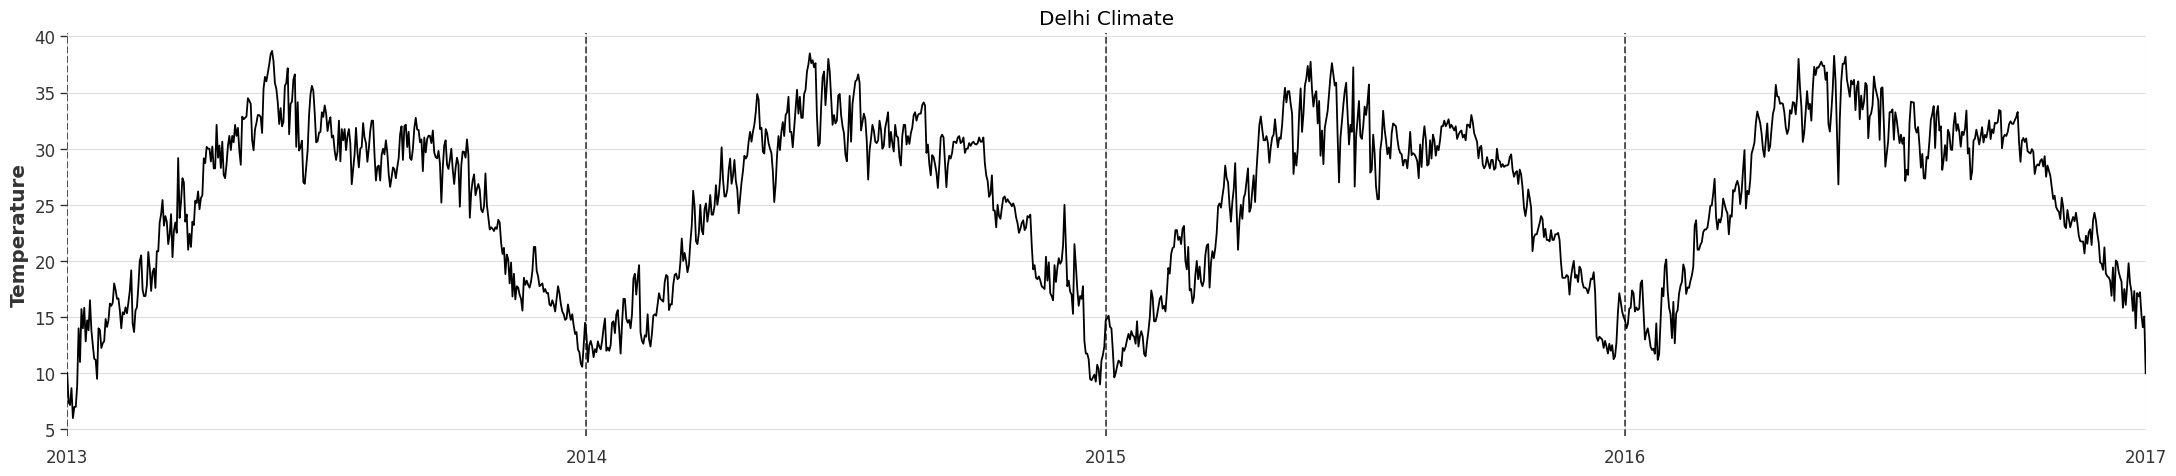

In [23]:
# Vars
# Unique years we have in the dataset:
min_year = np.unique(np.array(df["date"], dtype= 'datetime64[Y]')).min().astype(datetime).year
max_year = np.unique(np.array(df["date"], dtype= 'datetime64[Y]')).max().astype(datetime).year
# Main plot
df.set_index(["date"])["meantemp"].plot()
# Add vertical lines at each year to better visualize the yearly seasonality
for i  in range(min_year, max_year):
    plt.axvline(datetime(i,1,1), color='k', linestyle='--', alpha=0.7)
plt.xlabel("")
plt.title("Delhi Climate")
plt.ylabel("Temperature")
plt.tight_layout()

## 2) Train - Test

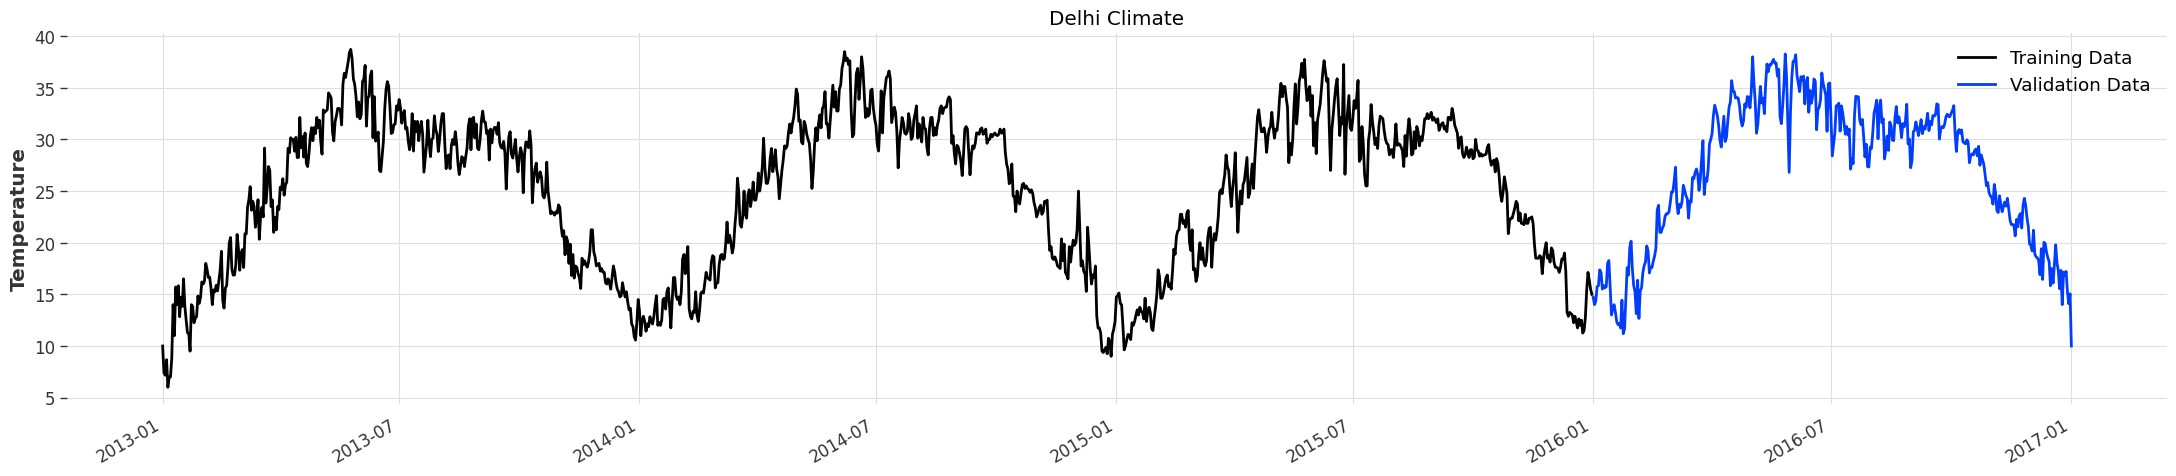

In [33]:
TRAIN_PERCENTAGE = 0.75
ts = darts.TimeSeries.from_series(df.set_index("date")["meantemp"])
train, val = ts.split_before(TRAIN_PERCENTAGE)
train.plot(label="Training Data")
val.plot(label="Validation Data")
plt.xlabel("")
plt.title("Delhi Climate")
plt.ylabel("Temperature")
plt.tight_layout()

## 3) Anomaly Detection
* **1)** Quantiles
* **2)** Thresholds: below 3% and above 97% as outliers. See more [here](https://unit8co.github.io/darts/generated_api/darts.ad.detectors.quantile_detector.html)

In [36]:
LOW_QUANTILE = 0.03
HIGH_QUANTILE = 0.97

anomaly_detector = QuantileDetector(low_quantile=LOW_QUANTILE, high_quantile=HIGH_QUANTILE)
anomalies = anomaly_detector.fit_detect(ts)

In [47]:
anomalies.pd_series().value_counts(normalize=True)

0.0000   0.9419
1.0000   0.0581
Name: proportion, dtype: float64

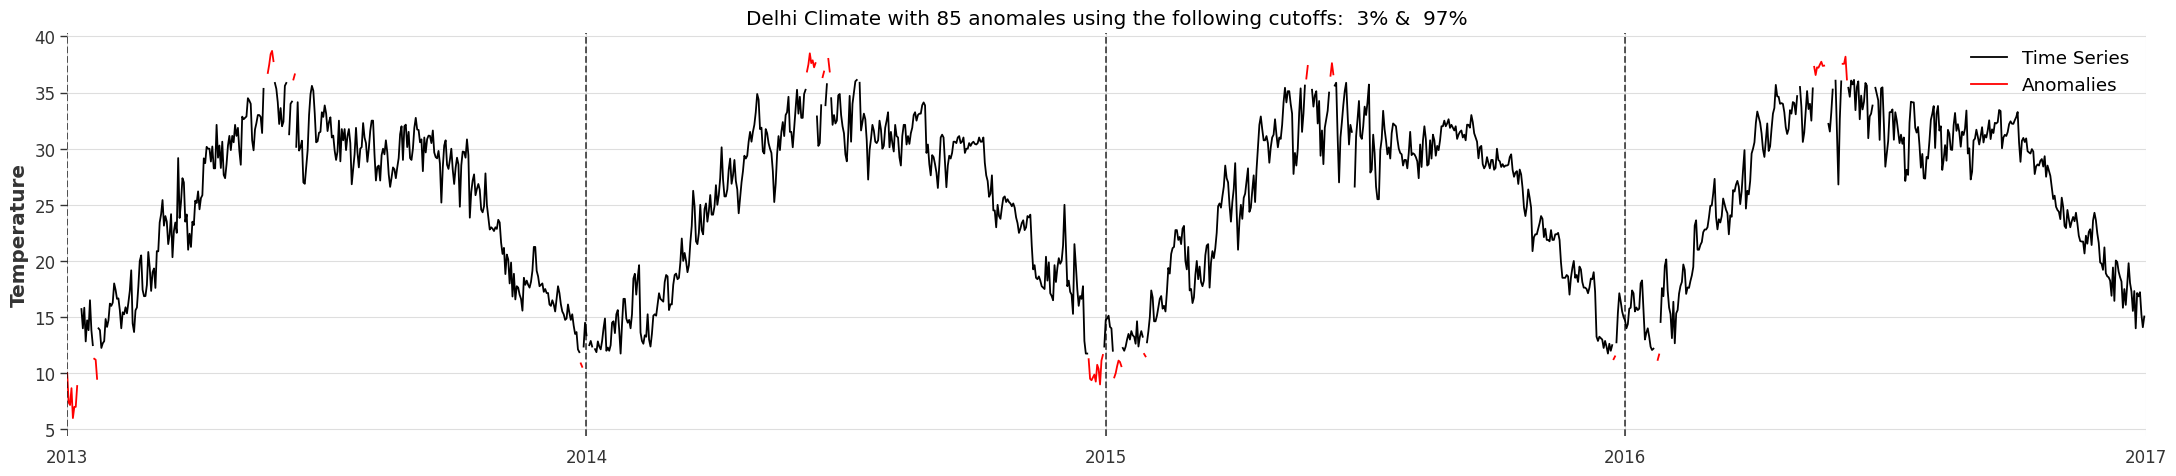

In [88]:
# Vars
anomaly_df = anomalies.pd_series().value_counts().reset_index().rename(columns={"index": "is_anomaly"})
number_anonalies = anomaly_df[anomaly_df["is_anomaly"] == 1]["count"].values.tolist()[0]

l = anomalies.pd_series().values
indexes = ts.pd_series().index
idx = pd.date_range(
        min(indexes), 
        max(indexes)
)

# Create DFs
anomalies_series = ts.pd_series()[np.array(l, dtype=bool)].reindex(idx, fill_value= np.nan)
nonanomalies_series = ts.pd_series()[~np.array(l, dtype=bool)].reindex(idx, fill_value= np.nan)
# Plots
nonanomalies_series.plot(color="black", label="Time Series")
anomalies_series.plot(color="red", label="Anomalies")
# Add vertical lines at each year to better visualize the yearly seasonality
for i  in range(min_year, max_year):
        plt.axvline(datetime(i,1,1), color='k', linestyle='--', alpha=0.7)
plt.title(f"Delhi Climate with {number_anonalies} anomales using the following cutoffs: {LOW_QUANTILE: .0%} & {HIGH_QUANTILE: .0%}")
plt.ylabel("Temperature")
plt.legend()
plt.tight_layout()